In [2]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/5153/Final Project/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/5153/Final Project/
/content/gdrive/My Drive/5153/Final Project


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')

train = train.iloc[:,[2,7,1]]
train.columns = ['text','party','label']
valid = valid.iloc[:,[2,7,1]]
valid.columns = ['text','party','label']
test = test.iloc[:,[2,7,1]]
test.columns = ['text','party','label']

def consolidate_label(x):
  a = []
  for i in x['label']:
    if i=='false':
      a.append('pants-fire')
    elif i=='half-true':
      a.append('barely-true')
    elif i=='mostly-true':
      a.append('true')
    else:
      a.append(i)
  return a

train['label'] = consolidate_label(train)
valid['label'] = consolidate_label(valid)
test['label'] = consolidate_label(test)

le = LabelEncoder()
le.fit(['barely-true','pants-fire','true'])
train['label'] = le.transform(train['label'])
valid['label'] = le.transform(valid['label'])
test['label'] = le.transform(test['label'])

print(train.shape)
print(valid.shape)
print(test.shape)

(10269, 3)
(1284, 3)
(1283, 3)


<ipython-input-5-8d99b4cbff40>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = consolidate_label(train)


In [6]:
train.head()

,text,party,label
0,Says the Annies List political group supports ...,republican,1
1,When did the decline of coal start? It started...,democrat,0
2,"Hillary Clinton agrees with John McCain ""by vo...",democrat,2
3,Health care reform legislation is likely to ma...,none,1
4,The economic turnaround started at the end of ...,democrat,0


In [7]:
# Function to clean text data
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply cleaning functions
train['text'] = train['text'].apply(clean_text).apply(remove_stopwords)
valid['text'] = valid['text'].apply(clean_text).apply(remove_stopwords)
test['text'] = test['text'].apply(clean_text).apply(remove_stopwords)


print(train.head())


                                                text       party  label
0  says annies list political group supports thir...  republican      1
1  decline coal start started natural gas took st...    democrat      0
2  hillary clinton agrees john mccain voting give...    democrat      2
3  health care reform legislation likely mandate ...        none      1
4               economic turnaround started end term    democrat      0


In [8]:
# Glove

glove_input_file = 'glove/glove.6B.100d.txt'
word2vec_output_file = 'glove/glove.6B.100d.txt.word2vec'

glove2word2vec(glove_input_file, word2vec_output_file)

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-8-605208f65750>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [9]:
# Sentence embedding
def sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    if not word_vectors:  # handle cases where none of the words are in the vocabulary
        return np.zeros(glove_model.vector_size)
    return np.mean(word_vectors, axis=0)

# Convert dataset texts to vectors
def convert_texts_to_vectors(texts, model):
    return np.array([sentence_embedding(text, glove_model) for text in texts])

In [10]:
X_train = convert_texts_to_vectors(train['text'], glove_model)
y_train = train['label'].values

X_valid = convert_texts_to_vectors(valid['text'], glove_model)
y_valid = valid['label'].values

X_test = convert_texts_to_vectors(test['text'], glove_model)
y_test = test['label'].values

## GLOVE + Lasso

In [11]:
logistic_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, multi_class='ovr')
logistic_model.fit(X_train, y_train)

test_probs = logistic_model.predict_proba(X_test)
test_preds = logistic_model.predict(X_test)

test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr', average='macro')

print("Test Classification Report:")
print(classification_report(y_test, logistic_model.predict(X_test), target_names=le.classes_, digits=4))
print("Test ROC AUC:", test_auc)

Test Classification Report:
              precision    recall  f1-score   support

 barely-true     0.4332    0.5052    0.4664       481
  pants-fire     0.4162    0.2398    0.3043       342
        true     0.4571    0.5217    0.4873       460

    accuracy                         0.4404      1283
   macro avg     0.4355    0.4222    0.4193      1283
weighted avg     0.4372    0.4404    0.4307      1283

Test ROC AUC: 0.6063857415598773


## GLOVE + CNN

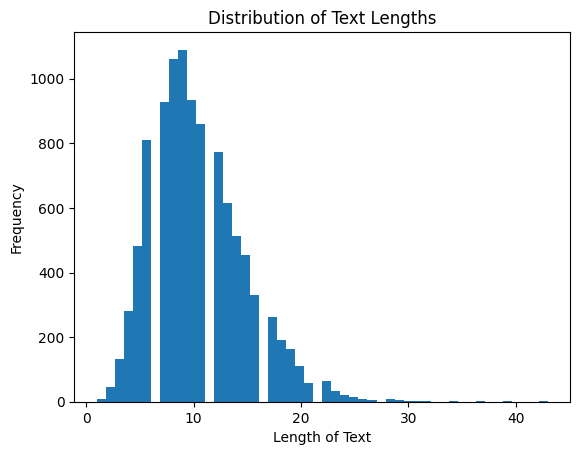

Max length is 43


In [12]:
train_texts = train['text'].tolist()

# Calculate the length of reviews
text_lengths = [len(text.split()) for text in train_texts]

# Plot the distribution of text lengths
plt.hist(text_lengths, bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

# Max length
maxlen = max(text_lengths)
print(f"Max length is {maxlen}")

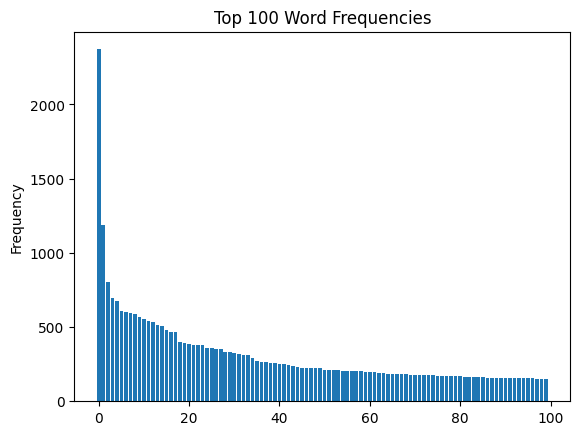

Maximum vocabulary size (number of unique words): 12225


In [13]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Summarize
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plot the top N word frequencies
top_N = 100
plt.bar(range(top_N), [freq for _, freq in sorted_word_counts[:top_N]])
plt.title('Top 100 Word Frequencies')
plt.ylabel('Frequency')
plt.show()

# Max vocab size
max_vocabulary_size = len(tokenizer.word_index)
print(f"Maximum vocabulary size (number of unique words): {max_vocabulary_size}")


In [18]:
python_random_seed = 2024
np.random.seed(python_random_seed)
random.seed(python_random_seed)
tf.random.set_seed(python_random_seed)


max_words = 15000  # Max vocab size
max_length = 50  # Max length of text sequences

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index

# Convert texts to sequences and pad them
sequence_train = tokenizer.texts_to_sequences(train['text'])
sequence_valid = tokenizer.texts_to_sequences(valid['text'])
sequence_test = tokenizer.texts_to_sequences(test['text'])

X_train_padded = pad_sequences(sequence_train, maxlen=max_length)
X_valid_padded = pad_sequences(sequence_valid, maxlen=max_length)
X_test_padded = pad_sequences(sequence_test, maxlen=max_length)

# Labels
num_classes = 3  # Number of classes
y_train = to_categorical(train['label'], num_classes)
y_valid = to_categorical(valid['label'], num_classes)
y_test = to_categorical(test['label'], num_classes)

#  Embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = glove_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Handle the case where the word is not in the GloVe vocabulary
            embedding_matrix[i] = np.zeros(embedding_dim)

# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_length,
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Compile and train the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_valid_padded, y_valid),
                    callbacks=[early_stopping])



# Evaluate and predict

test_probs = model.predict(X_test_padded)
test_predictions = np.argmax(test_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, test_predictions, target_names=le.classes_, digits = 4))
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy}')

test_probs = model.predict(X_test_padded)
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr', average='macro')
print("Test ROC AUC:", test_auc)


Epoch 1/15
321/321 [==============================] - 7s 18ms/step - loss: 1.0908 - accuracy: 0.3814 - val_loss: 1.0733 - val_accuracy: 0.3941
Epoch 2/15
321/321 [==============================] - 8s 24ms/step - loss: 1.0762 - accuracy: 0.3961 - val_loss: 1.0682 - val_accuracy: 0.4112
Epoch 3/15
321/321 [==============================] - 6s 18ms/step - loss: 1.0639 - accuracy: 0.4108 - val_loss: 1.0705 - val_accuracy: 0.4159
Epoch 4/15
321/321 [==============================] - 7s 23ms/step - loss: 1.0509 - accuracy: 0.4329 - val_loss: 1.0765 - val_accuracy: 0.4128
Epoch 5/15
321/321 [==============================] - 6s 18ms/step - loss: 1.0163 - accuracy: 0.4576 - val_loss: 1.0650 - val_accuracy: 0.4361
Epoch 6/15
321/321 [==============================] - 7s 21ms/step - loss: 0.9807 - accuracy: 0.4902 - val_loss: 1.1128 - val_accuracy: 0.4182
Epoch 7/15
321/321 [==============================] - 7s 20ms/step - loss: 0.9265 - accuracy: 0.5323 - val_loss: 1.1128 - val_accuracy: 0.4198